In [9]:
import sys
import json
import os
from datetime import datetime
import pyarrow.parquet as pq
import time
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sankey import Sankey
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Import tableone
try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne, load_dataset

In [10]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import config
config = config.load_config()

Loaded configuration from config.json


## please change site_name, tables_path, output_path, and file_type 

In [49]:
# Access configuration parameters
site_name = config['site_name']
tables_path = config['tables_path']
file_type = config['file_type']
output_path = os.path.join("..", "output", "final")

# Make sure the directory exists; if not, create it
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Print the configuration parameters
print(f"Site Name: {site_name}")
print(f"Tables Path: {tables_path}")
print(f"Output path: {output_path}")
print(f"File Type: {file_type}")

Site Name: UCMC
Tables Path: /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif
Output path: ../output/final
File Type: parquet


In [12]:
## Confirm that these are the correct paths
adt_filepath = f"{tables_path}/clif_adt.{file_type}"
hospitalization_filepath = f"{tables_path}/clif_hospitalization.{file_type}"
patient_filepath = f"{tables_path}/clif_patient.{file_type}"

In [13]:
def read_data(filepath, filetype):
    start_time = time.time()  # Record the start time
    file_name = os.path.basename(filepath) 
    if filetype == 'csv':
        df = pd.read_csv(filepath)
    elif filetype == 'parquet':
        table = pq.read_table(filepath)
        df = table.to_pandas()
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv' or 'parquet'.")
    
    end_time = time.time()  # Record the end time
    load_time = end_time - start_time  # Calculate the loading time
    
    # Calculate the size of the loaded dataset in MB
    dataset_size_mb = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"File name: {file_name}")
    print(f"Time taken to load the dataset: {load_time:.2f} seconds")
    print(f"Size of the loaded dataset: {dataset_size_mb:.2f} MB\n")
    
    return df

adt = read_data(adt_filepath, file_type)
hosp = read_data(hospitalization_filepath, file_type)
patient = read_data(patient_filepath,file_type)

File name: clif_adt.parquet
Time taken to load the dataset: 1.42 seconds
Size of the loaded dataset: 236.99 MB

File name: clif_hospitalization.parquet
Time taken to load the dataset: 0.91 seconds
Size of the loaded dataset: 2060.39 MB

File name: clif_patient.parquet
Time taken to load the dataset: 0.04 seconds
Size of the loaded dataset: 114.06 MB



In [14]:
print("number of unique hospitalization_id:",hosp["hospitalization_id"].nunique())

number of unique hospitalization_id: 4028866


In [15]:
missing_admission_dttm = hosp['admission_dttm'].isnull().sum()
print("Missing admission_dttm:", missing_admission_dttm)

Missing admission_dttm: 5051


In [16]:
hosp2 = hosp[["patient_id","hospitalization_id","admission_dttm","discharge_dttm","age_at_admission"]].copy()
hosp2['admission_dttm'] = pd.to_datetime(hosp2['admission_dttm'])
hosp2['discharge_dttm'] = pd.to_datetime(hosp2['discharge_dttm'])
hosp2 = hosp2[(hosp2['admission_dttm'].dt.year >= 2020) & 
                   (hosp2['admission_dttm'].dt.year <= 2021) & 
                   (hosp2['age_at_admission'] >=18)&
                    (hosp2['age_at_admission'] <=119)]

df = pd.merge(hosp2[["patient_id","hospitalization_id"]],
                  adt[["hospitalization_id","in_dttm","out_dttm","location_category"]],
             on="hospitalization_id",how="left")

print("number of unique hospitalization_id:",df["hospitalization_id"].nunique())
print("number of rows in df:",len(df))
df.head()

number of unique hospitalization_id: 1518129
number of rows in df: 1726690


patient_id hospitalization_id             in_dttm            out_dttm  \
0          6            1245635                 NaT                 NaT   
1          6           10086234                 NaT                 NaT   
2          6           11979360                 NaT                 NaT   
3          6           18531304                 NaT                 NaT   
4          6           20346665 2021-08-31 10:02:00 2021-08-31 19:36:00   

  location_category  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4        Procedural

In [17]:
df["location_category"] = df["location_category"].str.lower().str.strip()
# Mapping dictionary to update the location_category
location_mapping = {
    'rehab': 'Other',
    'l&d': 'Ward',
    'psych': 'Other',
    'radiology': 'Other',
    'dialysis': 'Other',
    'hospice': 'Other',
    'stepdown':'ICU',
    "icu": "ICU",
    "er": "ER",
    "ward":"Ward",
    "procedural":"Procedural",
    "other":"Other"
}

# Apply the mapping to the 'location_category' column
df['location_category'] = df['location_category'].replace(location_mapping)
df["location_category"].value_counts()

location_category
ER            179601
Ward           76285
Procedural     53954
Other          35368
ICU            15651
Name: count, dtype: int64

In [18]:
# Step 1: Sort by hospitalization_id and in_dttm
df = df.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])
df = df[df['location_category']!= "Other"] #removing "Other from the study"

# Step 2: Group by hospitalization_id and apply the removal logic
def remove_procedural_pattern(group):
    # Loop through the group to find the ICU --> Procedural --> ICU pattern
    to_remove = []
    
    for i in range(1, len(group) - 1):  # Start from second row and end before the last row
        # Check for ICU -> Procedural -> ICU pattern
        if (group.iloc[i-1]['location_category'] == 'ICU' and
            group.iloc[i]['location_category'] == 'Procedural' and
            group.iloc[i+1]['location_category'] == 'ICU'):
            # Mark the 'Procedural' row for removal
            to_remove.append(group.index[i])
    
    # Return the group without the rows to be removed
    return group.drop(to_remove)

# Apply the function to each group of hospitalization_id
df = df.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])
#stitch together ICUs if ICU --> procedure --> ICU
df['shifted_location'] = df['location_category'].shift(1)
df['new_location'] = (df['location_category'] != df['shifted_location']).cumsum()
df = df.groupby(['hospitalization_id','new_location']).agg(
    in_dttm=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    out_dttm=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'), 
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first')
).reset_index()
df = df.groupby('hospitalization_id').apply(remove_procedural_pattern).reset_index(drop=True)

print("Number of unique hospitalization_id:", df["hospitalization_id"].nunique())
print("Number of rows in df:",len(df))

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/4084998432.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('hospitalization_id').apply(remove_procedural_pattern).reset_index(drop=True)


Number of unique hospitalization_id: 1511315
Number of rows in df: 1584378


In [19]:
def remove_short_stays(df):
    # Ensure that the in_dttm and out_dttm columns are in datetime format
    df['in_dttm'] = pd.to_datetime(df['in_dttm'])
    df['out_dttm'] = pd.to_datetime(df['out_dttm'])
    
    # Calculate the time difference between out_dttm and in_dttm
    df['stay_duration'] = df['out_dttm'] - df['in_dttm']
    
    # Filter out rows where the stay duration is less than 1 hour
    df_filtered = df[df['stay_duration'] >= pd.Timedelta(hours=1)]
    
    # Drop the stay_duration column as it is no longer needed
    df_filtered = df_filtered.drop(columns=['stay_duration'])
    
    return df_filtered

# Sort the DataFrame as needed
df = df.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])

# Apply the function to the entire DataFrame, not with .apply()
df = remove_short_stays(df)

# Perform further transformations
df['shifted_location'] = df['location_category'].shift(1)
df['new_location'] = (df['location_category'] != df['shifted_location']).cumsum()

# Group by hospitalization_id and new_location, and aggregate
df = df.groupby(['hospitalization_id', 'new_location']).agg(
    in_dttm=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    out_dttm=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'),
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first')
).reset_index()

# Print summary information
print("Number of unique hospitalization_id:", df["hospitalization_id"].nunique())
print("Number of rows in df:", len(df))

Number of unique hospitalization_id: 143118
Number of rows in df: 214589


In [20]:
df['in_dttm'] = pd.to_datetime(df['in_dttm'])
df['out_dttm'] = pd.to_datetime(df['out_dttm'])
df = df.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])

def mark_procedural_before_second_icu(df):
    # Initialize the 'procedural' column with False
    df['procedural'] = False

    # Function to process each group of 'patient_id' and 'hospitalization_id'
    def process_group(group):
        # Find all the rows where the location is ICU
        icu_indices = group[group['location_category'] == 'ICU'].index

        # Check if at least two ICU admissions exist in the group
        if len(icu_indices) > 1:
            # Get the index of the second ICU admission
            second_icu_index = icu_indices[1]

            # Check the row just before the second ICU admission
            if second_icu_index > group.index[0]:
                row_before_second_icu = group.iloc[second_icu_index - group.index[0] - 1]

                # If the row before the second ICU is "Procedural", mark the entire group as procedural
                if row_before_second_icu['location_category'] == 'Procedural':
                    df.loc[group.index, 'procedural'] = True  # Mark the entire group as procedural

    # Apply the function to each group of 'patient_id' and 'hospitalization_id'
    df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)

    return df

df2 = df.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])
#making sure the dataset is aggregated correctly
df2['shifted_location'] = df2['location_category'].shift(1)
df2['new_location'] = (df2['location_category'] != df2['shifted_location']).cumsum()
df2 = df2.groupby(['hospitalization_id','new_location']).agg(
    in_dttm=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    out_dttm=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'), 
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first')
).reset_index()
df2 = mark_procedural_before_second_icu(df2)

# Output the updated DataFrame
print("Number of unique hospitalization_id:", df2["hospitalization_id"].nunique())
print("Number of rows in df:", len(df2))
print("Number of hospitalizations marked as procedural:", df2[df2["procedural"]==True]["hospitalization_id"].nunique())
df2[['patient_id', 'hospitalization_id', 'location_category', 'procedural']].head()

Number of unique hospitalization_id: 143118
Number of rows in df: 214589
Number of hospitalizations marked as procedural: 202


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/727362914.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)


patient_id hospitalization_id location_category  procedural
0    2479364           10000556              Ward       False
1    3642903           10001014                ER       False
2    3642903           10001014              Ward       False
3    3642903           10001014               ICU       False
4    3642903           10001014        Procedural       False

In [21]:
df2['in_dttm'] = pd.to_datetime(df2['in_dttm'])
df2['out_dttm'] = pd.to_datetime(df2['out_dttm'])
df2 = df2.sort_values(by=['hospitalization_id', 'in_dttm', 'out_dttm'])

# Function to filter visit_occurrence_ids based on ICU location
def filter_icu_visits(df):
    # Find all rows where location is ICU
    icu_visits = df[df['location_category'] == "ICU"]

    # If there are no ICU visits, return an empty DataFrame
    if icu_visits.empty:
        return pd.DataFrame(columns=df.columns)
    
    # Get the unique visit_occurrence_ids that include ICU
    icu_visit_ids = icu_visits['hospitalization_id'].unique()
    
    # Filter to include only rows with these visit_occurrence_ids (all ICU visits)
    df_filtered = df[df['hospitalization_id'].isin(icu_visit_ids)]
    
    return df_filtered

# Apply the function to each visit occurence to keep all ICU visits
icu_df = df2.groupby('hospitalization_id').apply(filter_icu_visits).reset_index(drop=True)
#icu_df = icu_df[icu_df['location_category'] != "Procedural"]
icu_df = icu_df.sort_values(by=['hospitalization_id', 'in_dttm','out_dttm'])

print("Number of unique hospitalization_id:", icu_df["hospitalization_id"].nunique())
print("Number of rows in df:",len(icu_df))

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/451336783.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  icu_df = df2.groupby('hospitalization_id').apply(filter_icu_visits).reset_index(drop=True)


Number of unique hospitalization_id: 11931
Number of rows in df: 39676


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/451336783.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  icu_df = df2.groupby('hospitalization_id').apply(filter_icu_visits).reset_index(drop=True)


In [24]:
def drop_deaths_during_icu(df, patient_df):
    # Merge death_dttm from patient data into icu_df
    df = pd.merge(df, patient_df[["patient_id", "death_dttm"]], on="patient_id", how="left")

    # Ensure the columns 'in_dttm' and 'out_dttm' are in datetime format
    df['death_dttm'] = pd.to_datetime(df['death_dttm'], errors='coerce').dt.tz_localize(None)
    df['in_dttm'] = pd.to_datetime(df['in_dttm'], errors='coerce').dt.tz_localize(None)
    df['out_dttm'] = pd.to_datetime(df['out_dttm'], errors='coerce').dt.tz_localize(None)

    # Sort the DataFrame by hospitalization_id and in_dttm for correct processing
    df = df.sort_values(by=['hospitalization_id', 'in_dttm'])

    # Identify first ICU admission per hospitalization
    icu_first_admission = df[df['location_category'] == 'ICU'].groupby('hospitalization_id').first().reset_index()

    # Identify hospitalization_id where the patient died during ICU admission
    death_during_icu = icu_first_admission[
        (icu_first_admission['death_dttm'].notnull()) &
        (icu_first_admission['death_dttm'] >= icu_first_admission['in_dttm']) &
        (icu_first_admission['death_dttm'] <= icu_first_admission['out_dttm'])
    ]['hospitalization_id']

    # Drop rows where the patient died during ICU admission
    dropped_df = df[df['hospitalization_id'].isin(death_during_icu)]
    df_cleaned = df[~df['hospitalization_id'].isin(death_during_icu)]

    return df_cleaned, dropped_df

icu_df = icu_df.sort_values(by=['hospitalization_id', 'in_dttm'])
icu_df2, dropped_deaths_df = drop_deaths_during_icu(icu_df, patient)

print("Number of unique hospitalization_id with death during ICU :",dropped_deaths_df["hospitalization_id"].nunique())
print("Number of unique hospitalization_id after removing death during ICU:", icu_df2["hospitalization_id"].nunique())
print("Number of rows in df:",len(icu_df2))

Number of unique hospitalization_id with death during ICU : 602
Number of unique hospitalization_id after removing death during ICU: 11329
Number of rows in df: 38303


In [25]:
def drop_direct_icu_discharges(df):
    # Initialize an empty list to hold custom_visit_occurrence2 values to be dropped
    visits_to_drop = []

    # Function to process each group of 'person_id' and 'custom_visit_occurrence2'
    def process_group(group):
        # Find all the rows where the location is ICU
        icu_indices = group[group['location_category'] == 'ICU'].index

        # Check if any ICU admissions exist in the group
        if not icu_indices.empty:
            # Get the index of the first ICU admission
            first_icu_index = icu_indices[0]

            # Check if this first ICU admission is also the last row in the visit
            if first_icu_index == group.index[-1]:
                # This means the patient was discharged or died directly from the ICU
                visits_to_drop.append(group.iloc[0]['hospitalization_id'])  # Mark the visit to be dropped

    # Apply the function to each group of 'person_id' and 'custom_visit_occurrence2'
    df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)

    # Create a new DataFrame with the rows that need to be dropped
    dropped_df = df[df['hospitalization_id'].isin(visits_to_drop)]

    # Drop the visits from the original DataFrame
    df_cleaned = df[~df['hospitalization_id'].isin(visits_to_drop)]

    return df_cleaned, dropped_df

icu_df2 = icu_df2.sort_values(by=['hospitalization_id', 'in_dttm','out_dttm'])
icu_df3, dropped_df_icu_discharge = drop_direct_icu_discharges(icu_df2)

# Output the counts and dropped DataFrame
print("Number of unique hospitalization_id after filtering:", icu_df3["hospitalization_id"].nunique())
print("Number of rows in df:",len(icu_df3))
print("Number of unique patient_id dropped:", dropped_df_icu_discharge["patient_id"].nunique())
print("Number of unique hospitalization_id dropped:", dropped_df_icu_discharge["hospitalization_id"].nunique())

Number of unique hospitalization_id after filtering: 9555
Number of rows in df: 34691
Number of unique patient_id dropped: 1667
Number of unique hospitalization_id dropped: 1774


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/3535290856.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)


In [26]:
#redundant but making sure that the location_category is grouped together 
icu_df4 = icu_df3.sort_values(by=['hospitalization_id', 'in_dttm','out_dttm'])
icu_df4['shifted_location'] = icu_df4['location_category'].shift(1)
icu_df4['new_location'] = (icu_df4['location_category'] != icu_df4['shifted_location']).cumsum()

icu_df4 = icu_df4.groupby(['hospitalization_id','new_location']).agg(
    earliest_location_start=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    latest_location_end=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'), 
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first'),
    procedural = pd.NamedAgg(column='procedural', aggfunc='first')
).reset_index()

print("Number of unique hospitalization_id:", icu_df4["hospitalization_id"].nunique())
icu_df4.head()

Number of unique hospitalization_id: 9555


hospitalization_id  new_location earliest_location_start  \
0           10001014             1     2021-09-07 07:07:00   
1           10001014             2     2021-09-07 19:36:00   
2           10001014             3     2021-09-08 21:28:00   
3           10001014             4     2021-09-10 07:20:00   
4           10001014             5     2021-09-11 18:21:00   

  latest_location_end location_category patient_id procedural  
0 2021-09-07 19:36:00                ER    3642903      False  
1 2021-09-08 21:28:00              Ward    3642903      False  
2 2021-09-11 18:21:00               ICU    3642903      False  
3 2021-09-10 14:24:00        Procedural    3642903      False  
4 2021-09-14 20:30:00              Ward    3642903      False

In [27]:
def drop_intermediate_er(df):
    # Initialize an empty list to hold hospitalization_id values to be dropped
    visits_to_drop = []

    # Function to process each group of 'patient_id' and 'hospitalization_id'
    def process_group(group):
        # Check if 'ER' appears after the first row in the group
        if any(group.iloc[1:]['location_category'] == 'ER'):
            # Mark the visit for dropping if 'ER' appears after the first row
            visits_to_drop.append(group.iloc[0]['hospitalization_id'])

    # Apply the function to each group of'hospitalization_id'
    df.groupby(['hospitalization_id']).apply(process_group)

    # Create a new DataFrame with the rows that need to be dropped
    dropped_df = df[df['hospitalization_id'].isin(visits_to_drop)]

    # Drop the visits from the original DataFrame
    df_cleaned = df[~df['hospitalization_id'].isin(visits_to_drop)]

    return df_cleaned, dropped_df

# Sort and apply the drop function
icu_df4 = icu_df4.sort_values(by=['hospitalization_id', 'earliest_location_start', 'latest_location_end'])
icu_df5, dropped_df = drop_intermediate_er(icu_df4)

# Convert to datetime and calculate location hours
icu_df5['earliest_location_start'] = pd.to_datetime(icu_df5['earliest_location_start'])
icu_df5['latest_location_end'] = pd.to_datetime(icu_df5['latest_location_end'])
icu_df5['location_hours'] = (icu_df5['latest_location_end'] - icu_df5['earliest_location_start']).dt.total_seconds() / 3600

# Output the results
print("Number of rows in df:", len(icu_df5))
print("Number of unique hospitalization_id:", icu_df5["hospitalization_id"].nunique())
icu_df5.head()

Number of rows in df: 34691
Number of unique hospitalization_id: 9555


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/1379404485.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['hospitalization_id']).apply(process_group)


hospitalization_id  new_location earliest_location_start  \
0           10001014             1     2021-09-07 07:07:00   
1           10001014             2     2021-09-07 19:36:00   
2           10001014             3     2021-09-08 21:28:00   
3           10001014             4     2021-09-10 07:20:00   
4           10001014             5     2021-09-11 18:21:00   

  latest_location_end location_category patient_id procedural  location_hours  
0 2021-09-07 19:36:00                ER    3642903      False       12.483333  
1 2021-09-08 21:28:00              Ward    3642903      False       25.866667  
2 2021-09-11 18:21:00               ICU    3642903      False       68.883333  
3 2021-09-10 14:24:00        Procedural    3642903      False        7.066667  
4 2021-09-14 20:30:00              Ward    3642903      False       74.150000

# creating the readmission flag

In [28]:
def calculate_icu_readmission_time(df):
    # Initialize a new column 'ICU_readmission_hour' with None
    df['ICU_readmission_hour'] = None

    # Function to process each group
    def process_group(group):
        # Find the rows where location_category is ICU
        icu_rows = group[group['location_category'] == 'ICU']

        # Check if there are at least two ICU events
        if len(icu_rows) > 1:
            # Sort by earliest_start2 to ensure correct order
            icu_rows = icu_rows.sort_values(by='earliest_location_start')

            # Get the first and second ICU event
            first_icu = icu_rows.iloc[0]
            second_icu = icu_rows.iloc[1]

            # Calculate the time difference between first and second ICU events in hours
            time_diff = (second_icu['earliest_location_start'] - first_icu['latest_location_end']).total_seconds() / 3600

            # Update the entire group with the calculated time difference
            df.loc[group.index, 'ICU_readmission_hour'] = time_diff

    # Apply the function to each group of 'person_id' and 'custom_visit_occurrence2'
    df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)

    return df

icu_df6 = calculate_icu_readmission_time(icu_df5)
print("number of rows in df:",len(icu_df6))
print("Number of unique hospitalization_id:", icu_df6["hospitalization_id"].nunique())

number of rows in df: 34691
Number of unique hospitalization_id: 9555


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/784593150.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['patient_id', 'hospitalization_id']).apply(process_group)


In [29]:
# Identify hospitalization_ids where ICU_readmission_hour is less than 0
#This is in place incase there are errors in the adt, should be a very small number if any 
hosp_ids_to_drop = icu_df6[icu_df6["ICU_readmission_hour"] <=0]["hospitalization_id"].unique()

# Drop rows with those hospitalization_ids
icu_df7 = icu_df6[~icu_df6["hospitalization_id"].isin(hosp_ids_to_drop)]

# Check the result
print("Number of unique hospitalization_id after filtering:", icu_df7["hospitalization_id"].nunique())
print("Number of rows in df after filtering:", len(icu_df7))

Number of unique hospitalization_id after filtering: 9544
Number of rows in df after filtering: 34617


In [ ]:
#pd.set_option('display.max_rows',None)

In [ ]:
#icu_df6[icu_df6["ICU_readmission_hour"]>0][:100]

In [30]:
# Select relevant columns
icu_final = icu_df7[["patient_id", "hospitalization_id", "ICU_readmission_hour","procedural"]]

# Drop duplicates based on 'custom_visit_occurrence2'
icu_final = icu_final.drop_duplicates(subset=["hospitalization_id"])

# Display the first few rows of the result
print("Number of rows in df:",len(icu_final))
print("Number of unique patient_id:", icu_final["patient_id"].nunique())
print("Number of unique hospitalization_id:", icu_final["hospitalization_id"].nunique())
icu_final.head()

Number of rows in df: 9544
Number of unique patient_id: 8258
Number of unique hospitalization_id: 9544


patient_id hospitalization_id ICU_readmission_hour procedural
0     3642903           10001014                 None      False
5     3428122           10001954                 None      False
10    4839715           10014077                 None      False
13     707179           10019863                 None      False
17    4765469            1002459                 None      False

# create table 

In [31]:
total_unique_visits = icu_final["hospitalization_id"].nunique()
unique_visits_with_procedures = icu_final[icu_final["procedural"]==True]["hospitalization_id"].nunique()
unique_visits_without_procedures = icu_final[icu_final["procedural"]==False]["hospitalization_id"].nunique()
all_icu_readmission = icu_final[(icu_final["ICU_readmission_hour"]>0)]["hospitalization_id"].nunique()
all_icu_readmission_6hours = icu_final[(icu_final["ICU_readmission_hour"]<6)]["hospitalization_id"].nunique()
all_icu_readmission_24hours = icu_final[(icu_final["ICU_readmission_hour"]<24)]["hospitalization_id"].nunique()
all_icu_readmission_48hours = icu_final[(icu_final["ICU_readmission_hour"]<48)]["hospitalization_id"].nunique()
all_icu_readmission_72hours = icu_final[(icu_final["ICU_readmission_hour"]<72)]["hospitalization_id"].nunique()
unplanned_icu_readmission = icu_final[(icu_final["procedural"]==False)&(icu_final["ICU_readmission_hour"]>0)]["hospitalization_id"].nunique()
unplanned_icu_readmission_6hours = icu_final[(icu_final["procedural"]==False)&(icu_final["ICU_readmission_hour"]<6)]["hospitalization_id"].nunique()
unplanned_icu_readmission_24hours = icu_final[(icu_final["procedural"]==False)&(icu_final["ICU_readmission_hour"]<24)]["hospitalization_id"].nunique()
unplanned_icu_readmission_48hours = icu_final[(icu_final["procedural"]==False)&(icu_final["ICU_readmission_hour"]<48)]["hospitalization_id"].nunique()
unplanned_icu_readmission_72hours = icu_final[(icu_final["procedural"]==False)&(icu_final["ICU_readmission_hour"]<72)]["hospitalization_id"].nunique()


print("Number of unique hospitalization_id:", total_unique_visits)
print("Planned readmission: Number of unique hospitalization_id with procedures between ICU readmission:", unique_visits_with_procedures)
print("Unplanned readmission: Number of unique hospitalization_id without any procedures between ICU readmission:", unique_visits_without_procedures)

all_icu_read = round((all_icu_readmission / total_unique_visits)*100,2)
all_6hrs = round((all_icu_readmission_6hours/total_unique_visits)*100,2)
all_24hrs = round((all_icu_readmission_24hours/total_unique_visits)*100,2)
all_48hrs = round((all_icu_readmission_48hours/total_unique_visits)*100,2)
all_72hrs = round((all_icu_readmission_72hours/total_unique_visits)*100,2)

unplanned_icu_read = round((unplanned_icu_readmission / unique_visits_without_procedures)*100,2)
unplanned_6hrs = round((unplanned_icu_readmission_6hours/unique_visits_without_procedures)*100,2)
unplanned_24hrs = round((unplanned_icu_readmission_24hours/unique_visits_without_procedures)*100,2)
unplanned_48hrs = round((unplanned_icu_readmission_48hours/unique_visits_without_procedures)*100,2)
unplanned_72hrs = round((unplanned_icu_readmission_72hours/unique_visits_without_procedures)*100,2)

# Print all readmission rate
print(f"All ICU readmission ({all_icu_readmission}/{total_unique_visits}): {all_icu_read}%")
print(f"All ICU readmission <6hr ({all_icu_readmission_6hours}/{total_unique_visits}): {all_6hrs}%")
print(f"All ICU readmission <24hr ({all_icu_readmission_24hours}/{total_unique_visits}): {all_24hrs}%")
print(f"All ICU readmission <48hr ({all_icu_readmission_48hours}/{total_unique_visits}): {all_48hrs}%")
print(f"All ICU readmission <72hr ({all_icu_readmission_72hours}/{total_unique_visits}): {all_72hrs}%")

# Print unplanned readmission rate
print(f"Unplanned ICU readmission ({unplanned_icu_readmission}/{unique_visits_without_procedures}): {unplanned_icu_read}%")
print(f"Unplanned ICU readmission <6hr ({unplanned_icu_readmission_6hours}/{unique_visits_without_procedures}): {unplanned_6hrs}%")
print(f"Unplanned ICU readmission <24hr ({unplanned_icu_readmission_24hours}/{unique_visits_without_procedures}): {unplanned_24hrs}%")
print(f"Unplanned ICU readmission <48hr ({unplanned_icu_readmission_48hours}/{unique_visits_without_procedures}): {unplanned_48hrs}%")
print(f"Unplanned ICU readmission <72hr ({unplanned_icu_readmission_72hours}/{unique_visits_without_procedures}): {unplanned_72hrs}%")

Number of unique hospitalization_id: 9544
Planned readmission: Number of unique hospitalization_id with procedures between ICU readmission: 197
Unplanned readmission: Number of unique hospitalization_id without any procedures between ICU readmission: 9347
All ICU readmission (974/9544): 10.21%
All ICU readmission <6hr (32/9544): 0.34%
All ICU readmission <24hr (179/9544): 1.88%
All ICU readmission <48hr (358/9544): 3.75%
All ICU readmission <72hr (475/9544): 4.98%
Unplanned ICU readmission (777/9347): 8.31%
Unplanned ICU readmission <6hr (32/9347): 0.34%
Unplanned ICU readmission <24hr (168/9347): 1.8%
Unplanned ICU readmission <48hr (330/9347): 3.53%
Unplanned ICU readmission <72hr (431/9347): 4.61%


In [57]:
data = {
    'Metric': [
        'All ICU Readmission', 
        'All ICU Readmission <6hr', 
        'All ICU Readmission <24hr', 
        'All ICU Readmission <48hr', 
        'All ICU Readmission <72hr', 
        'Unplanned ICU Readmission', 
        'Unplanned ICU Readmission <6hr', 
        'Unplanned ICU Readmission <24hr', 
        'Unplanned ICU Readmission <48hr', 
        'Unplanned ICU Readmission <72hr'
    ],
    'Numerator/Denominator': [
        f"{all_icu_readmission}/{total_unique_visits}", 
        f"{all_icu_readmission_6hours}/{total_unique_visits}", 
        f"{all_icu_readmission_24hours}/{total_unique_visits}", 
        f"{all_icu_readmission_48hours}/{total_unique_visits}", 
        f"{all_icu_readmission_72hours}/{total_unique_visits}", 
        f"{unplanned_icu_readmission}/{unique_visits_without_procedures}", 
        f"{unplanned_icu_readmission_6hours}/{unique_visits_without_procedures}", 
        f"{unplanned_icu_readmission_24hours}/{unique_visits_without_procedures}", 
        f"{unplanned_icu_readmission_48hours}/{unique_visits_without_procedures}", 
        f"{unplanned_icu_readmission_72hours}/{unique_visits_without_procedures}"
    ],
    'Percentage (%)': [
        all_icu_read, 
        all_6hrs, 
        all_24hrs, 
        all_48hrs, 
        all_72hrs, 
        unplanned_icu_read, 
        unplanned_6hrs, 
        unplanned_24hrs, 
        unplanned_48hrs, 
        unplanned_72hrs
    ]
}
# Create the DataFrame
final_df = pd.DataFrame(data)
final_df.to_csv(f'{output_path}/ICU_readmission_rates_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
final_df

Metric Numerator/Denominator  Percentage (%)
0              All ICU Readmission              974/9544           10.21
1         All ICU Readmission <6hr               32/9544            0.34
2        All ICU Readmission <24hr              179/9544            1.88
3        All ICU Readmission <48hr              358/9544            3.75
4        All ICU Readmission <72hr              475/9544            4.98
5        Unplanned ICU Readmission              777/9347            8.31
6   Unplanned ICU Readmission <6hr               32/9347            0.34
7  Unplanned ICU Readmission <24hr              168/9347            1.80
8  Unplanned ICU Readmission <48hr              330/9347            3.53
9  Unplanned ICU Readmission <72hr              431/9347            4.61

# Generate Sankey Plot

In [33]:
dropped_deaths_df2 = dropped_deaths_df.rename(columns={
    'in_dttm': 'earliest_location_start',
    'out_dttm': 'latest_location_end'
})

dropped_df_icu_discharge2 = dropped_df_icu_discharge.rename(columns={
    'in_dttm': 'earliest_location_start',
    'out_dttm': 'latest_location_end'
})

print(dropped_deaths_df2["hospitalization_id"].nunique())
print(dropped_df_icu_discharge2["hospitalization_id"].nunique())

602
1774


In [34]:
icu_df7_death = pd.concat([dropped_df_icu_discharge2[["patient_id","hospitalization_id","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]], 
                           dropped_deaths_df2[["patient_id","hospitalization_id","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]]], axis=0)
icu_df7_death = pd.concat([icu_df7_death, icu_df7[["patient_id","hospitalization_id","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]]], axis=0)

icu_df7_death = pd.merge(icu_df7_death,patient[["patient_id","death_dttm"]],on="patient_id",how="left")
icu_df7_death = pd.merge(icu_df7_death,hosp[["hospitalization_id","discharge_category"]],on="hospitalization_id",how="left")


icu_df7_death.head()
print("Number of rows in df:",len(icu_df7_death))
print("Number of unique patient_id:", icu_df7_death["patient_id"].nunique())
print("Number of unique hospitalization_id:", icu_df7_death["hospitalization_id"].nunique())

Number of rows in df: 42473
Number of unique patient_id: 10196
Number of unique hospitalization_id: 11920


In [36]:
def mark_deaths(df):
    # Ensure the columns are in datetime format
    df['death_dttm'] = pd.to_datetime(df['death_dttm'], errors='coerce').dt.tz_localize(None)
    df['earliest_location_start'] = pd.to_datetime(df['earliest_location_start'], errors='coerce').dt.tz_localize(None)
    df['latest_location_end'] = pd.to_datetime(df['latest_location_end'], errors='coerce').dt.tz_localize(None)

    # Create the location_category_death column as a copy of location_category
    df['location_category_death'] = df['location_category']

    # Sort the dataframe by patient_id, hospitalization_id, and earliest_location_start to ensure order
    df = df.sort_values(by=['hospitalization_id', 'earliest_location_start'])

    # List to collect new rows that represent the death
    new_rows = []

    # Iterate over each group of hospitalization_id
    for hospitalization_id, group in df.groupby('hospitalization_id'):
        for idx, row in group.iterrows():
            # Check if death_dttm is between earliest_location_start and latest_location_end
            if (
                not pd.isna(row['death_dttm']) and 
                row['earliest_location_start'] <= row['death_dttm'] <= row['latest_location_end']
            ):
                # Create a new row with the same info but marked as 'Death'
                new_row = row.copy()
                new_row['location_category_death'] = 'Died'
                new_row['earliest_location_start'] = row['latest_location_end'] + pd.Timedelta(seconds=1)  # Add 1 second to ensure 'Death' comes after
                new_rows.append(new_row)

    # Add the new death rows to the original dataframe
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    # Sort the dataframe again to make sure 'Death' comes after the original location
    df = df.sort_values(by=['hospitalization_id', 'earliest_location_start']).reset_index(drop=True)

    return df

# Sort and apply the death marking function
icu_df7_death = mark_deaths(icu_df7_death)
print("Number of dead patients:", icu_df7_death[icu_df7_death["location_category_death"] == "Died"]["hospitalization_id"].nunique())
print("Number of rows in df:", len(icu_df7_death))
print("Number of unique hospitalization_id:", icu_df7_death["hospitalization_id"].nunique())

Number of dead patients: 859
Number of rows in df: 43396
Number of unique hospitalization_id: 11920


In [37]:
icu_df7_death[icu_df7_death["location_category_death"]=="Died"][["hospitalization_id",
                                                                  "earliest_location_start",
                                                                 "latest_location_end",
                                                                 "death_dttm",
                                                                 "location_category",
                                                                 "location_category_death"]].head()

hospitalization_id earliest_location_start latest_location_end  \
12             1000314     2020-07-11 17:05:01 2020-07-11 17:05:00   
29            10023490     2021-12-11 07:30:01 2021-12-11 07:30:00   
73            10054561     2021-02-25 00:29:01 2021-02-25 00:29:00   
82            10059989     2021-10-25 13:17:01 2021-10-25 13:17:00   
175           10101939     2020-09-02 00:50:01 2020-09-02 00:50:00   

             death_dttm location_category location_category_death  
12  2020-07-11 00:00:00               ICU                    Died  
29  2021-12-11 01:03:00               ICU                    Died  
73  2021-02-24 00:00:00               ICU                    Died  
82  2021-10-25 00:00:00               ICU                    Died  
175 2020-09-02 00:00:00              Ward                    Died

## This code chunk takes longer to run: 

In [38]:
def collapse_segments(df):
    # Ensure data is sorted by 'earliest_location_start'
    df = df.sort_values('earliest_location_start').reset_index(drop=True)

    # Create a new column to track if the location was ICU in the original location_category
    df['is_icu_in_location_category'] = (df['location_category'] == 'ICU')

    # Detect changes in location category, both in the original and in the death-adjusted version
    df['loc_cat_change'] = (df['location_category_death'] != df['location_category_death'].shift(1)).astype(int)

    # Assign a segment_id that increments when location_category_death changes
    df['segment_id'] = df['loc_cat_change'].cumsum()

    # Group by 'segment_id' and 'location_category_death' to merge consecutive segments
    grouped = df.groupby(['segment_id', 'location_category_death']).agg({
        'earliest_location_start': 'min',
        'latest_location_end': 'max',
        'is_icu_in_location_category': 'max'  # Capture whether any part of the segment was ICU
    }).reset_index()

    # Add 'hospitalization_id' to the grouped DataFrame
    grouped['hospitalization_id'] = df['hospitalization_id'].iloc[0]

    # Rearrange columns
    grouped = grouped[['hospitalization_id', 'segment_id', 'earliest_location_start', 'latest_location_end', 'location_category_death', 'is_icu_in_location_category']]
    
    # Initialize 'segment_rank' to None
    grouped['segment_rank'] = None

    # Now we can still find ICU segments based on the original location_category, but respect Death as a location in location_category_death
    icu_segments = grouped[grouped['is_icu_in_location_category'] == 1]

    if icu_segments.empty:
        print(f"No ICU segments for hospitalization_id: {df['hospitalization_id'].iloc[0]}")
        return pd.DataFrame()  # Return empty DataFrame to exclude this hospitalization

    # Get the index of the first ICU segment
    first_icu_index = icu_segments.index[0]

    # Create 'segment_rank' starting from the first ICU segment
    grouped.loc[first_icu_index:, 'segment_rank'] = range(1, len(grouped.loc[first_icu_index:]) + 1)

    # Fill in the 'segment_rank' for non-ICU segments after the first ICU
    grouped['segment_rank'] = grouped['segment_rank'].ffill()

    # Compute the maximum segment rank for this hospitalization
    max_segment_rank = grouped['segment_rank'].dropna().max()

    # Add 'max_segment_rank' column to the DataFrame
    grouped['max_segment_rank'] = max_segment_rank

    # Drop the auxiliary column
    grouped = grouped.drop(columns=['is_icu_in_location_category'])

    return grouped

# Apply the function to the DataFrame
collapsed_adt = icu_df7_death[icu_df7_death["procedural"] == False][['hospitalization_id', 'earliest_location_start', 'latest_location_end', 'location_category', 'location_category_death']] \
    .groupby('hospitalization_id', group_keys=False).apply(collapse_segments).reset_index(drop=True)

print("Number of unique hospitalization_id:", collapsed_adt["hospitalization_id"].nunique())
print("Number of rows in df:", len(collapsed_adt))

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/3468692749.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped['segment_rank'] = grouped['segment_rank'].ffill()
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/3468692749.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped['segment_rank'] = grouped['segment_rank'].ffill()
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/3468692749.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change

Number of unique hospitalization_id: 11723
Number of rows in df: 39170


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/3468692749.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  collapsed_adt = icu_df7_death[icu_df7_death["procedural"] == False][['hospitalization_id', 'earliest_location_start', 'latest_location_end', 'location_category', 'location_category_death']] \


In [39]:
def drop_intermediate_er2(df):
    # Initialize an empty list to hold hospitalization_id values to be dropped
    visits_to_drop = []

    # Function to process each group of 'patient_id' and 'hospitalization_id'
    def process_group(group):
        # Check if 'ER' appears after the first row in the group
        if any(group.iloc[1:]['location_category_death'] == 'ER'):
            # Mark the visit for dropping if 'ER' appears after the first row
            visits_to_drop.append(group.iloc[0]['hospitalization_id'])

    # Apply the function to each group of'hospitalization_id'
    df.groupby(['hospitalization_id']).apply(process_group)

    # Create a new DataFrame with the rows that need to be dropped
    dropped_df = df[df['hospitalization_id'].isin(visits_to_drop)]

    # Drop the visits from the original DataFrame
    df_cleaned = df[~df['hospitalization_id'].isin(visits_to_drop)]

    return df_cleaned, dropped_df

collapsed_adt = collapsed_adt.sort_values(by=['hospitalization_id', 'earliest_location_start', 'latest_location_end'])
collapsed_adt2, dropped_df = drop_intermediate_er2(collapsed_adt)

print("Number of unique hospitalization_id:", collapsed_adt2["hospitalization_id"].nunique())
print("Number of rows in df:", len(collapsed_adt2))

Number of unique hospitalization_id: 11723
Number of rows in df: 39170


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_17702/166403339.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['hospitalization_id']).apply(process_group)


In [40]:
sankey_df = collapsed_adt2.reset_index().loc[:,['hospitalization_id','segment_rank','location_category_death']]
sankey_df2 = sankey_df.loc[sankey_df.segment_rank.notna()] 
sankey_df3 = sankey_df2.pivot(
    index=['hospitalization_id'],
    columns='segment_rank',
    values='location_category_death'
).reset_index().fillna('Discharged')
sankey_df4 = sankey_df3.iloc[:, :8] #only take first 7 locations, otherwise gets too long

In [41]:
def propagate_death(df):
    # List of columns that represent the different segments
    segment_cols = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Find the first occurrence of "Death" in the segment columns
        death_found = False
        for col in segment_cols:
            if row[col] == 'Died':
                death_found = True
            # If "Death" is found, mark all subsequent columns as "Death"
            if death_found:
                df.at[idx, col] = 'Died'
    
    return df

# Apply the function to propagate 'Death' to subsequent columns
sankey_df4 = propagate_death(sankey_df4)

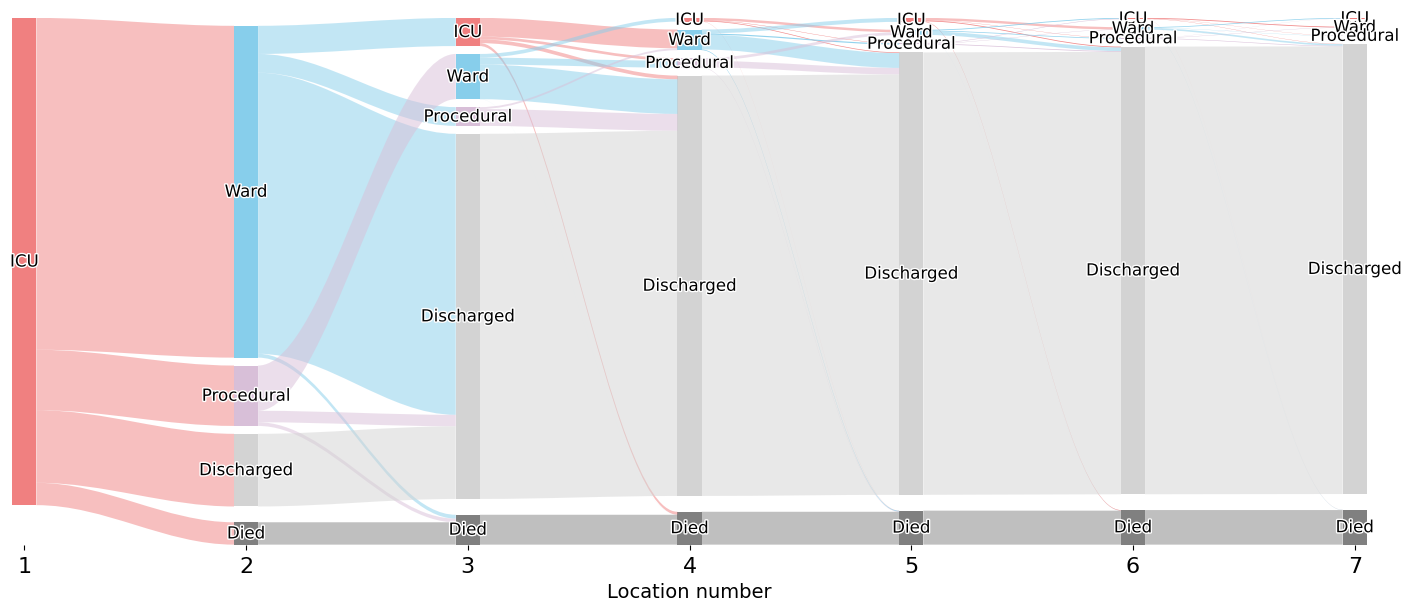

In [59]:
colors = {
    "ICU": 'lightcoral',
    "Ward": 'skyblue',
    'Procedural':'thistle',
    "Discharged": 'lightgrey',
    "Died": 'grey',
    "ER":'red'
}
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
diag = Sankey(
    sankey_df4.iloc[:, 1:], 
    ax=ax, 
    order=["ICU", "Ward", "Procedural", "Discharged","ER","Died"],
    block_width=0.2,
    colors=colors,
    alpha=0.5
)
diag.draw()
ax.set_title("", size=16)
ax.set_xticks(
    [diag.block_width / 2 + diag.flow_width * x + diag.block_width * x for x in range(sankey_df4.shape[1] - 1)]
)
ax.set_xticklabels(sankey_df4.columns[1:].astype(int))
ax.set_xlabel("Location number", size=14)
ax.get_xaxis().set_visible(True)
ax.tick_params(axis="x", pad=5, labelsize=16)

# Export the figure as a high-resolution image
fig.savefig(f'{output_path}/sankey_diagram_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png', dpi=300, bbox_inches='tight')

# Generate Table One

In [43]:
unplanned_icu_final = icu_final[icu_final["procedural"]==False]
#admission location
admission_location = icu_df7[["hospitalization_id", "location_category"]].groupby('hospitalization_id', as_index=False).first()
unplanned_icu_final = pd.merge(unplanned_icu_final,admission_location,on="hospitalization_id",how="left")

#length of ICU stay 
icu_sorted = icu_df7.sort_values(by=['hospitalization_id', 'earliest_location_start'])
icu_first_icu = icu_sorted[icu_sorted['location_category'] == 'ICU'].groupby('hospitalization_id', as_index=False).first()
length_ICU = icu_first_icu[['hospitalization_id', 'location_hours']]
unplanned_icu_final = pd.merge(unplanned_icu_final,length_ICU,on="hospitalization_id",how="left")
unplanned_icu_final['location_days'] = unplanned_icu_final['location_hours'] / 24

#in-hospital mortality
dead_patients = collapsed_adt2[collapsed_adt2["location_category_death"]=="Died"][["hospitalization_id","location_category_death"]]
unplanned_icu_final = pd.merge(unplanned_icu_final,dead_patients,on="hospitalization_id",how="left")
unplanned_icu_final['location_category_death'] = unplanned_icu_final['location_category_death'].fillna('Alive')

#age at admission
hosp = hosp.drop_duplicates(subset=["hospitalization_id"])
age = hosp[["hospitalization_id","age_at_admission"]]                           
unplanned_icu_final = pd.merge(unplanned_icu_final,age,on="hospitalization_id",how="left")

#demographics 
demog = patient[["patient_id","race_category","ethnicity_category","sex_category"]]
unplanned_icu_final = pd.merge(unplanned_icu_final,demog,on="patient_id",how="left")
unplanned_icu_final = unplanned_icu_final.drop_duplicates(subset=["hospitalization_id"])

#readmitted
unplanned_icu_final['readmission'] = unplanned_icu_final['ICU_readmission_hour'].apply(
    lambda x: 'Readmitted' if pd.notna(x) and x > 0 else 'Not Readmitted'
)

print(unplanned_icu_final["hospitalization_id"].nunique())
unplanned_icu_final.head()

9347


patient_id hospitalization_id ICU_readmission_hour procedural  \
0    3642903           10001014                 None      False   
1    3428122           10001954                 None      False   
2    4839715           10014077                 None      False   
3     707179           10019863                 None      False   
4    4765469            1002459                 None      False   

  location_category  location_hours  location_days location_category_death  \
0                ER       68.883333       2.870139                   Alive   
1              Ward       39.166667       1.631944                   Alive   
2                ER       34.900000       1.454167                   Alive   
3                ER      701.150000      29.214583                   Alive   
4               ICU       96.583333       4.024306                   Alive   

   age_at_admission              race_category ethnicity_category  \
0              74.0  Black or African American       Not Hispanic   
1              68.0                      White       Not Hispanic   
2              69.0  Black or African American       Not Hispanic   
3              63.0  Black or African American       Not Hispanic   
4              73.0  Black or African American       Not Hispanic   

  sex_category     readmission  
0       Female  Not Readmitted  
1       Female  Not Readmitted  
2       Female  Not Readmitted  
3         Male  Not Readmitted  
4         Male  Not Readmitted

In [44]:
table_one_dat = unplanned_icu_final[["age_at_admission",
                                     "sex_category",
                                     "race_category",
                                    "ethnicity_category",
                                    "location_category",
                                     "ICU_readmission_hour",
                                    "location_days",
                                    "location_category_death",
                                    "readmission"]]

# Rename columns
table_one_dat = table_one_dat.rename(columns={'age_at_admission': 'Age', 
                                              'sex_category': 'Sex', 
                                              'race_category': 'Race',
                                             'ethnicity_category': 'Ethnicity',
                                             'location_category': 'Initial hospital location',
                                              'ICU_readmission_hour':'ICU readmission, hours',
                                              "location_days":'ICU length of stay, days',
                                              "location_category_death":'In-hospital Mortality'
                                             })

In [61]:
# Define the columns that include both continuous and categorical variables
columns = ["Age", "ICU readmission, hours", "ICU length of stay, days", "Sex", "Race", "Ethnicity", "Initial hospital location", "In-hospital Mortality"]

# Define which columns are categorical
categorical = ["Sex", "Race", "Ethnicity", "Initial hospital location", "In-hospital Mortality"]

# Define which continuous variables are not normally distributed
nonnormal = ["Age","ICU readmission, hours","ICU length of stay, days"]

#groupby
groupby = 'readmission'

# Generate the TableOne object
table1 = TableOne(data=table_one_dat, 
                  columns=columns, 
                  categorical=categorical, 
                  nonnormal=nonnormal, 
                  groupby=groupby)

# Display the table

table1.to_csv(f'{output_path}/table1_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
table1

/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission/readmit_venv/lib/python3.9/site-packages/tableone/tableone.py:570: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(x.values),  # type: ignore
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1

Grouped by readmission                                                        
                                                                                                  Missing            Overall    Not Readmitted         Readmitted
n                                                                                                                       9347              8570                777
Age, median [Q1,Q3]                                                                                     0   60.0 [45.0,70.0]  60.0 [44.0,70.0]   63.0 [51.0,73.0]
ICU readmission, hours, median [Q1,Q3]                                                               8570  62.5 [26.9,126.3]     nan [nan,nan]  62.5 [26.9,126.3]
ICU length of stay, days, median [Q1,Q3]                                                                0      2.1 [1.1,4.1]     2.0 [1.1,4.0]      2.8 [1.4,5.4]
Sex, n (%)                               Female                                                                  4078 (43.6)       3781 (44.1)         297 (38.2)
                                         Male                                                                    5269 (56.4)       4789 (55.9)         480 (61.8)
Race, n (%)                              American Indian or Alaska Native                                           17 (0.2)          17 (0.2)                   
                                         Asian                                                                     158 (1.7)         143 (1.7)           15 (1.9)
                                         Black or African American                                               6249 (66.9)       5738 (67.0)         511 (65.8)
                                         Native Hawaiian or Other Pacific Islander                                  15 (0.2)          14 (0.2)            1 (0.1)
                                         None                                                                       29 (0.3)          27 (0.3)            2 (0.3)
                                         Other                                                                     369 (3.9)         332 (3.9)           37 (4.8)
                                         Unknown                                                                   173 (1.9)         158 (1.8)           15 (1.9)
                                         White                                                                   2337 (25.0)       2141 (25.0)         196 (25.2)
Ethnicity, n (%)                         Hispanic                                                                  544 (5.8)         494 (5.8)           50 (6.4)
                                         Not Hispanic                                                            8663 (92.7)       7951 (92.8)         712 (91.6)
                                         Unknown                                                                   140 (1.5)         125 (1.5)           15 (1.9)
Initial hospital location, n (%)         ER                                                                      6222 (66.6)       5721 (66.8)         501 (64.5)
                                         ICU                                                                       775 (8.3)         678 (7.9)          97 (12.5)
                                         Procedural                                                              1640 (17.5)       1550 (18.1)          90 (11.6)
                                         Ward                                                                      710 (7.6)         621 (7.2)          89 (11.5)
In-hospital Mortality, n (%)             Alive                                                                   9129 (97.7)       8478 (98.9)         651 (83.8)
                                         Died                                                                      218 (2.3)          92 (1.1)         126 (16.2)